In [1]:
import bioframe as bf
from datasets import load_dataset
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

/accounts/projects/yss/gbenegas/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = "results/SGE/DDX3X/processed"

In [3]:
models = [
    "CADD.RawScore",
    "phyloP",
    "phastCons",
    "phyloP-Zoonomia",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = load_dataset(f"../../{dataset_path}", split="test").to_pandas()
d = Path(f"../../results/preds/{dataset_path}")

for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,consequence,category,label,CADD,phyloP-100-vertebrates,phastCons-100-vertebrates,phyloP-241-mammals,GPN-MSA
0,X,41334228,T,A,5_prime_UTR_variant,noncoding,unchanged,-1.099151,-0.352,-0.435,0.354,-4.820312
1,X,41334228,T,G,5_prime_UTR_variant,noncoding,unchanged,-1.112464,-0.352,-0.435,0.354,-4.269531
2,X,41334228,T,C,5_prime_UTR_variant,noncoding,unchanged,-1.232743,-0.352,-0.435,0.354,-4.886719
3,X,41334229,C,A,5_prime_UTR_variant,noncoding,unchanged,-1.548775,-3.034,-0.997,-2.180,-7.417969
4,X,41334229,C,G,5_prime_UTR_variant,noncoding,unchanged,-1.566415,-3.034,-0.997,-2.180,-6.660156
...,...,...,...,...,...,...,...,...,...,...,...,...
7939,X,41347733,T,G,3_prime_UTR_variant,noncoding,unchanged,-1.195731,-1.099,-1.000,-0.233,-6.003906
7940,X,41347733,T,C,3_prime_UTR_variant,noncoding,unchanged,-1.234965,-1.099,-1.000,-0.233,-3.699219
7941,X,41347734,A,T,3_prime_UTR_variant,noncoding,unchanged,-1.259134,-1.670,-1.000,-0.642,-6.132812
7942,X,41347734,A,C,3_prime_UTR_variant,noncoding,unchanged,-1.272620,-1.670,-1.000,-0.642,-5.945312


In [4]:
V.dropna(subset=models, inplace=True)
V.shape

(7944, 12)

In [5]:
V["old_label"] = V.label
V.label = V.label != "unchanged"

In [6]:
rows = []
V_c = V.copy()
for m in models:
    AUROC = roc_auc_score(V_c.label, -V_c[m])
    AUPRC = average_precision_score(V_c.label, -V_c[m])
    rows.append([m, AUROC, AUPRC])
results = pd.DataFrame(rows, columns=["Model", "AUROC", "AUPRC"]).sort_values("AUPRC", ascending=False)
results

,Model,AUROC,AUPRC
0,CADD,0.848617,0.656515
4,GPN-MSA,0.800088,0.532442
1,phyloP-100-vertebrates,0.742329,0.426382
3,phyloP-241-mammals,0.690910,0.372401
2,phastCons-100-vertebrates,0.637770,0.297994


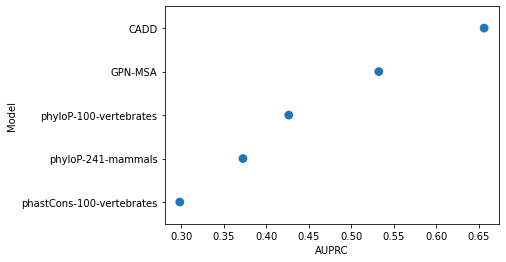

In [7]:
sns.pointplot(data=results, y="Model", x="AUPRC", join=False);

<Axes: xlabel='GPN-MSA', ylabel='Count'>

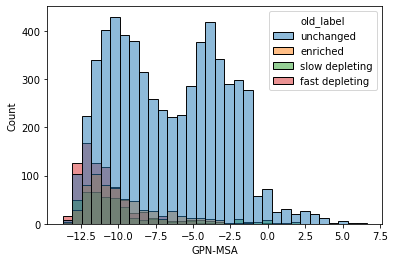

In [8]:
sns.histplot(data=V, x="GPN-MSA", hue="old_label")

<Axes: xlabel='CADD', ylabel='Count'>

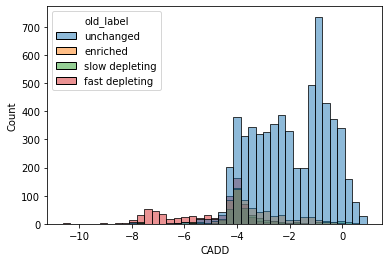

In [9]:
sns.histplot(data=V, x="CADD", hue="old_label")